In [1]:
source("https://bioconductor.org/biocLite.R")
biocLite("DESeq2")

Bioconductor version 3.6 (BiocInstaller 1.28.0), ?biocLite for help
BioC_mirror: https://bioconductor.org
Using Bioconductor 3.6 (BiocInstaller 1.28.0), R 3.4.3 (2017-11-30).
Installing package(s) ‘DESeq2’
also installing the dependencies ‘knitr’, ‘htmlwidgets’, ‘htmlTable’, ‘base64enc’, ‘Hmisc’

Updating HTML index of packages in '.Library'
Making 'packages.html' ... done
Old packages: 'curl', 'RSQLite', 'stringi', 'stringr'


In [2]:
library(rhdf5)
library(edgeR)
library(MAST)
library(splatter)
library(DESeq2)

Loading required package: limma
Loading required package: SummarizedExperiment
Loading required package: GenomicRanges
Loading required package: stats4
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following object is masked from ‘package:limma’:

    plotMA

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, cbind, colMeans, colnames,
    colSums, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, lengths, Map, mapply, match,
    mget, order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, 

In [3]:
splat_simulate = function(input_rda, facLoc=1, facScale=0.3, deProb=0.1, dropoutPresent=FALSE, groupProb, batch_cells)
{
   # Estimate parameters from the data (it takes time, could be moved out of the function)
    # loads the params object from the rda
    load(input_rda)
    params = setParam(params, "group.prob", groupProb)
    params = setParam(params, "de.facScale", facScale)
    params = setParam(params, "de.prob", deProb)
    params = setParam(params, "de.facLoc", facLoc)
    params = setParam(params, "dropout.present", dropoutPresent)
    params = setParam(params, "batchCells", batch_cells)
    print(params)
    sg = splatSimulateGroups(param=params, verbose=TRUE)
    return (sg)
}

In [4]:
input_rda = '../hdf5_data/melanomaS2_estimated.rda'

In [5]:
group_prob = c(0.5,0.5)
dropout_present = TRUE
loc_factor = 5.25
de_prob = 0.2
batch_cells = 50

In [6]:
sg = splat_simulate(input_rda = input_rda, groupProb = group_prob, dropoutPresent=dropout_present, facLoc = loc_factor, deProb=de_prob, batch_cells = batch_cells)

A Params object of class SplatParams 
Parameters can be (estimable) or [not estimable], 'Default' or 'NOT DEFAULT'. 

Global: 
(GENES)  (CELLS)   [Seed]  
  19928       50   345813  

27 additional parameters 

Batches: 
    [Batches]  [BATCH CELLS]     [Location]        [Scale]  
            1             50            0.1            0.1  

Mean: 
           (RATE)            (SHAPE)  
  6.4424992377419  0.450391841248872  

Library size: 
       (LOCATION)            (SCALE)  
   8.604201321772  0.566294779432438  

Exprs outliers: 
     (PROBABILITY)          (LOCATION)             (SCALE)  
0.0128667295213798    5.45189725088042   0.948377631424917  

Groups: 
     [GROUPS]  [GROUP PROBS]  
            2       0.5, 0.5  

Diff expr: 
[PROBABILITY]    [Down Prob]     [LOCATION]        [SCALE]  
          0.2            0.5           5.25            0.3  

BCV: 
    (COMMON DISP)              (DOF)  
0.375807272815026   32.8043787886285  

Dropout: 
         [PRESENT]          (MIDPO

Getting parameters...
Creating simulation object...
Simulating library sizes...
Simulating gene means...
Simulating group DE...
Simulating cell means...
Simulating BCV...
Simulating counts..
Simulating dropout (if needed)...
Done!


In [7]:
group2_mask = (colData(sg)$Group == 'Group2')

In [8]:
table(colData(sg)$Group)


Group1 Group2 
    27     23 

In [9]:
matrix = assays(sg)$counts
groups = colData(sg)$Group
group2_mask = (colData(sg)$Group == 'Group2')
group1_mask = !group2_mask

In [10]:
groups

[1] "Group2" "Group2" "Group1" "Group1" "Group2" "Group1" "Group1" "Group1"
 [9] "Group2" "Group2" "Group1" "Group2" "Group1" "Group2" "Group2" "Group1"
[17] "Group2" "Group2" "Group1" "Group1" "Group1" "Group1" "Group1" "Group2"
[25] "Group1" "Group1" "Group2" "Group1" "Group1" "Group2" "Group1" "Group1"
[33] "Group1" "Group1" "Group2" "Group1" "Group2" "Group1" "Group2" "Group2"
[41] "Group1" "Group2" "Group2" "Group2" "Group1" "Group2" "Group1" "Group1"
[49] "Group2" "Group2"

In [11]:
length(group2_mask)

[1] 50

In [12]:
group = groups
counts = assays(sg)$counts

In [13]:
#remove all-zero rows
matrix_nonzero = matrix[rowSums(matrix != 0) > 0, ]

In [106]:
apply_wilcox = function (matrix_nonzero, group1_mask, group2_mask)
{
    ## Wilcox/Mann-Whitney-U Test
    # run the test (for each gene):
    pVals <- apply(
        matrix, 1, function(x) {
            # performs the test between one cell group and all the other cells
            wilcox.test(
                x[group1_mask], 
                x[group2_mask]
            )$p.value
        }
    )
    return (pVals <- p.adjust(pVals, method = "fdr"))  
}

In [107]:
apply_ks = function (matrix_nonzero, group1_mask, group2_mask)
{
    ## Wilcox/Mann-Whitney-U Test
    # run the test (for each gene):
    pVals <- apply(
        matrix, 1, function(x) {
            # performs the test between one cell group and all the other cells
            ks.test(
                x[group1_mask], 
                x[group2_mask]
            )$p.value
        }
    )
    return (pVals <- p.adjust(pVals, method = "fdr"))  
}

In [108]:
evaluate = function (pVals, cell_group, gene_attrs, gene_names)
{
    # evaluation using the ground truth
    group_defac = paste('DEFac', cell_group, sep="") #DEFacGroup5
    de_genes_g5 = gene_names[gene_attrs[group_defac][[1]] != 1]
    non_de_genes_g5 = gene_names[gene_attrs[group_defac][[1]] == 1]
    
    # roc calculations
    pVals <- pVals[gene_names %in% de_genes_g5 |
                   gene_names %in% non_de_genes_g5]
    truth <- rep(1, times = length(pVals));
    truth[gene_names %in% de_genes_g5] = 0;
    pred <- ROCR::prediction(pVals, truth)
    perf <- ROCR::performance(pred, "tpr", "fpr")
    ROCR::plot(perf)
    aucObj <- ROCR::performance(pred, "auc")
    #write the detected de genes & p-values to a csv
    #plot the roc & auc score to a csv
    return (aucObj@y.values[[1]])
}

In [109]:
pvals = apply_wilcox(matrix,group1_mask, group2_mask)

Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value wi

“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_

“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_

“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_

“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_

“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_

“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_

“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_

“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_

“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_

“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_

“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_

“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_

“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_

“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_

“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_

“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_

“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_

“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_

“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_

“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_

“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_

“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_

“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_

“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_

“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_

“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_

“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_

“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_

“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_

“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_

“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_

“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_

“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_

“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_

“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_

“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_

“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_

“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_

“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_

“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_

“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_

“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_

“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_

“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_

“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_

“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_

“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_

“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_

“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_

“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_

“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_

“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_

“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_

“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_

“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_

“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_

“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_

“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_

“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_

“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_

“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_

“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_

“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_

“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_

“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_

“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_

“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_

“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_

“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_

“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_

“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_

“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_

“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_

“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_

“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_

“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_

“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_

“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_

“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_

“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_

“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_

“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_

“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_

“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_

“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_

“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_

“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_

“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_

“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_

“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_

“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_

“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_

“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_

“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_

“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_

“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_

“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_

“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_

“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_

“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_

“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_

“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_

“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_

“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_

“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_

“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_

“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_

“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_

“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_

“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_

“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_

“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_

“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_

“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_

“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_

“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_

“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_

“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_

“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_

“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_

“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_

“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_

“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_

“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_

“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_

“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_

“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_

“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_

“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_

“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_

“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_

“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_

“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_

“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_

“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_

“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_mask]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x[group1_mask], x[group2_

In [66]:
ks_pvals = apply_ks(matrix,group1_mask, group2_mask)

Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], x[group2_mask]):
“p-value will be approximate in the presence of ties”Warning message in ks.test(x[group1_mask], 

In [15]:
evaluate(pVals = ks_pvals, cell_group='Group2', gene_attrs=rowData(sg), gene_names=rownames(sg))

ERROR: Error in evaluate(pVals = ks_pvals, cell_group = "Group2", gene_attrs = rowData(sg), : object 'ks_pvals' not found


[1] 0.6671442

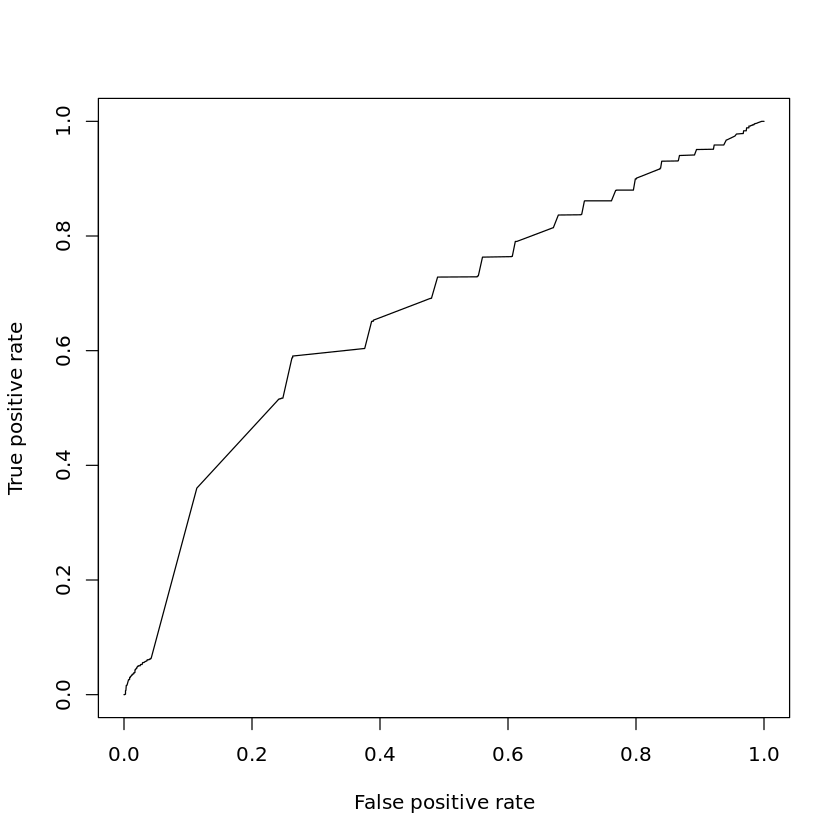

In [110]:
evaluate(pVals = pvals, cell_group='Group2', gene_attrs=rowData(sg), gene_names=rownames(sg))

In [17]:
evaluate(pVals = pvals, cell_group='Group1', gene_attrs=rowData(sg), gene_names=rownames(sg))

[1] 0.6950984

## EdgeR
Binarize the groups into two: the given cell group or not

In [18]:
apply_edger = function (matrix, binary_groups)
{
    counts = matrix    
    dge <- DGEList(counts = counts, group = binary_groups)
    group_edgeR <- factor(binary_groups)
    design <- model.matrix(~ group_edgeR)
    dge <- estimateCommonDisp(dge, design = design, trend.method = "none")
    #dge <- estimateTrendedDisp(dge, design = design, trend.method = "none")
    #dge <- estimateTagwiseDisp(dge, design = design, trend.method = "none")
    fit <- glmFit(dge, design)
    res <- glmLRT(fit)
    return (res)
}

In [19]:
edger_res = apply_edger(matrix_nonzero, group2_mask)

In [20]:
edger_padj = p.adjust(edger_res$table$PValue, method = "fdr")

In [21]:
evaluate(pVals = edger_padj, cell_group='Group2', gene_attrs=rowData(sg), gene_names=rownames(sg))

[1] 0.5015235

## Monocle

In [6]:
source("https://bioconductor.org/biocLite.R")
biocLite("monocle")

Bioconductor version 3.6 (BiocInstaller 1.28.0), ?biocLite for help
BioC_mirror: https://bioconductor.org
Using Bioconductor 3.6 (BiocInstaller 1.28.0), R 3.4.3 (2017-11-30).
Installing package(s) ‘monocle’
Updating HTML index of packages in '.Library'
Making 'packages.html' ... done
Old packages: 'curl', 'RSQLite', 'stringi', 'stringr'


In [62]:
library(monocle)

In [63]:
?differentialGeneTest

In [42]:
sessionInfo()

R version 3.4.3 (2017-11-30)
Platform: x86_64-conda_cos6-linux-gnu (64-bit)
Running under: CentOS Linux 7 (Core)

Matrix products: default
BLAS/LAPACK: /cluster/work/bewi/members/tuncel/anaconda3/envs/pipe-env/lib/R/lib/libRblas.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
 [1] splines   parallel  stats4    stats     graphics  grDevices utils    
 [8] datasets  methods   base     

other attached packages:
 [1] monocle_2.6.4              DDRTree_0.1.5             
 [3] irlba_2.3.2                VGAM_1.0-5                
 [5] Matrix_1.2-13              BiocInstaller_1.28.0      
 [7] splatter_1.2.2             scater_1.6.3              
 [9] Sin

In [64]:
group = groups

In [65]:
group

[1] "Group2" "Group2" "Group1" "Group1" "Group2" "Group1" "Group1" "Group1"
 [9] "Group2" "Group2" "Group1" "Group2" "Group1" "Group2" "Group2" "Group1"
[17] "Group2" "Group2" "Group1" "Group1" "Group1" "Group1" "Group1" "Group2"
[25] "Group1" "Group1" "Group2" "Group1" "Group1" "Group2" "Group1" "Group1"
[33] "Group1" "Group1" "Group2" "Group1" "Group2" "Group1" "Group2" "Group2"
[41] "Group1" "Group2" "Group2" "Group2" "Group1" "Group2" "Group1" "Group1"
[49] "Group2" "Group2"

In [66]:
pd <- data.frame(group = group)
rownames(pd) <- colnames(counts)

In [67]:
pd <- new("AnnotatedDataFrame", data = pd)

In [68]:
pd

An object of class 'AnnotatedDataFrame'
  rowNames: Cell1 Cell2 ... Cell50 (50 total)
  varLabels: group
  varMetadata: labelDescription

In [69]:
Obj <- newCellDataSet(
    as.matrix(matrix), 
    phenoData = pd, 
    expressionFamily = negbinomial.size())

Warning message in newCellDataSet(as.matrix(matrix), phenoData = pd, expressionFamily = negbinomial.size()):
“Warning: featureData must contain a column verbatim named 'gene_short_name' for certain functions”Warning message in newCellDataSet(as.matrix(matrix), phenoData = pd, expressionFamily = negbinomial.size()):
“Warning: featureData must contain a column verbatim named 'gene_short_name' for certain functions”Warning message in newCellDataSet(as.matrix(matrix), phenoData = pd, expressionFamily = negbinomial.size()):
“Warning: featureData must contain a column verbatim named 'gene_short_name' for certain functions”

In [70]:

Obj <- estimateSizeFactors(Obj)
Obj <- estimateDispersions(Obj)
res <- differentialGeneTest(Obj, fullModelFormulaStr = "~group")

pVals <- res[,3]
names(pVals) <- rownames(res)
pVals <- p.adjust(pVals, method = "fdr")


Warning message:
“glm.fit: algorithm did not converge”Removing 166 outliers
Warning message:
“glm.fit: algorithm did not converge”

In [71]:
length(pVals)

[1] 19928

[1] 0.5773998

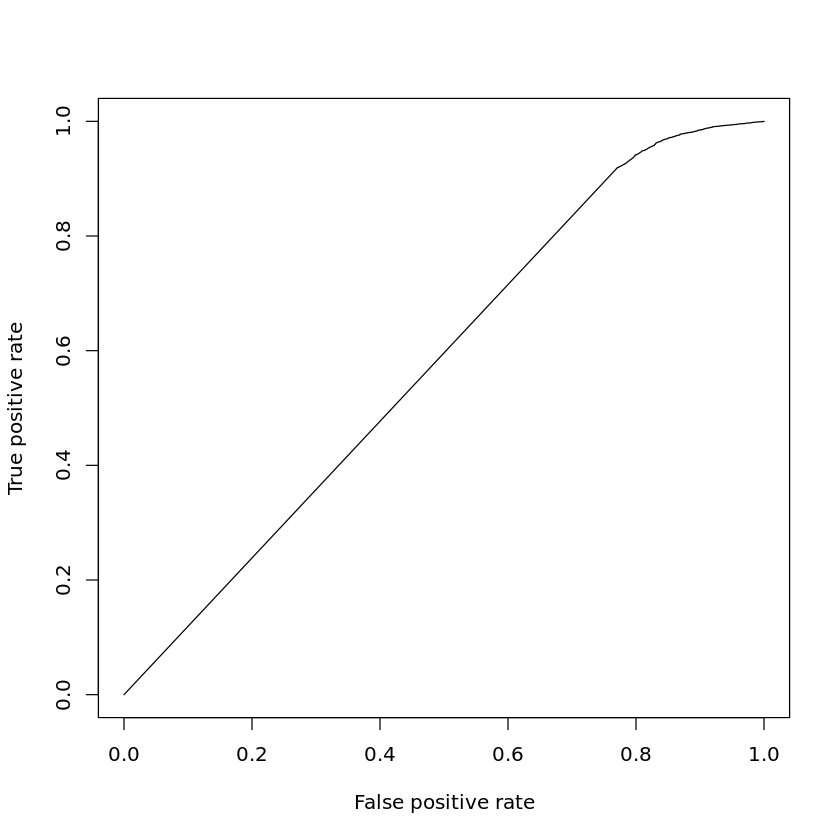

In [72]:
evaluate(pVals = pVals, cell_group='Group2', gene_attrs=rowData(sg), gene_names=rownames(sg))

## MAST

## SCDE

In [96]:
source("https://bioconductor.org/biocLite.R")
biocLite("scde")

Bioconductor version 3.6 (BiocInstaller 1.28.0), ?biocLite for help
BioC_mirror: https://bioconductor.org
Using Bioconductor 3.6 (BiocInstaller 1.28.0), R 3.4.3 (2017-11-30).
Installing package(s) ‘scde’
also installing the dependencies ‘rematch’, ‘forcats’, ‘hms’, ‘readr’, ‘cellranger’, ‘foreign’, ‘haven’, ‘readxl’, ‘openxlsx’, ‘minqa’, ‘nloptr’, ‘RcppEigen’, ‘carData’, ‘pbkrtest’, ‘maptools’, ‘rio’, ‘lme4’, ‘modeltools’, ‘nlme’, ‘brew’, ‘SparseM’, ‘MatrixModels’, ‘Lmoments’, ‘distillery’, ‘car’, ‘flexmix’, ‘RcppArmadillo’, ‘mgcv’, ‘Rook’, ‘Cairo’, ‘quantreg’, ‘nnet’, ‘RMTstat’, ‘extRemes’, ‘pcaMethods’

Warning message in install.packages(pkgs = doing, lib = lib, ...):
“installation of package ‘Cairo’ had non-zero exit status”Warning message in install.packages(pkgs = doing, lib = lib, ...):
“installation of package ‘scde’ had non-zero exit status”Updating HTML index of packages in '.Library'
Making 'packages.html' ... done
Old packages: 'curl', 'RSQLite', 'stringi', 'stringr'


In [95]:
library(scde)
cnts <- apply(
    matrix_nonzero,
    2,
    function(x) {
        storage.mode(x) <- 'integer'
        return(x)
    }
)
names(group) <- 1:length(group)
colnames(cnts) <- 1:length(group)
o.ifm <- scde::scde.error.models(
    counts = cnts,
    groups = group,
    n.cores = 1,
    threshold.segmentation = TRUE,
    save.crossfit.plots = FALSE,
    save.model.plots = FALSE,
    verbose = 0,
    min.size.entries = 2
)
priors <- scde::scde.expression.prior(
    models = o.ifm,
    counts = cnts,
    length.out = 400,
    show.plot = FALSE
)
resSCDE <- scde::scde.expression.difference(
    o.ifm,
    cnts,
    priors,
    groups = group,
    n.randomizations = 100,
    n.cores = 1,
    verbose = 0
)
# Convert Z-scores into 2-tailed p-values
pVals <- pnorm(abs(resSCDE$cZ), lower.tail = FALSE) * 2
DE_Quality_AUC(pVals)

ERROR: Error in library(scde): there is no package called ‘scde’


In [77]:
counts = matrix
binary_groups = group1_mask

In [80]:
log_counts <- log(counts + 1) / log(2)
fData <- data.frame(names = rownames(sg))
rownames(fData) <- rownames(sg);
cData <- data.frame(cond = binary_groups)
rownames(cData) <- colnames(log_counts)

obj <- FromMatrix(as.matrix(log_counts), cData, fData)
colData(obj)$cngeneson <- scale(colSums(assay(obj) > 0))
cond <- factor(colData(obj)$cond)

# Model expression as function of condition & number of detected genes
zlmCond <- zlm(~ cond + cngeneson, obj) 

`fData` has no primerid.  I'll make something up.
`cData` has no wellKey.  I'll make something up.
.....................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [87]:
zlmCond

Fitted zlm on 19928 genes and 500 cells.
 Using BayesGLMlike ~ cond + cngeneson 

In [88]:
summaryCond <- summary(zlmCond)
summaryDt <- summaryCond$datatable

summaryDt <- as.data.frame(summaryDt)
pVals <- unlist(summaryDt[summaryDt$component == "H",4]) # H = hurdle model


Combining coefficients and standard errors
Calculating log-fold changes


In [86]:
pVals

numeric(0)

In [82]:
names(pVals) <- unlist(summaryDt[summaryDt$component == "H",1])
pVals <- p.adjust(pVals, method = "fdr")


In [24]:
pVals

named numeric(0)

In [59]:
evaluate(pVals, cell_group)

ERROR: Error in ROCR::prediction(pVals, truth): Number of classes is not equal to 2.
ROCR currently supports only evaluation of binary classification tasks.


## Limma

In [111]:
# *** Running Limma:

Run_Limma = function(rawData, gr1, gr2){
  
    require(limma)

    filtered = apply(rawData,1, function(x) {if(all(x == 0)) return (FALSE) else return(TRUE)})
    FilteredData = rawData[filtered,]

    # Samples' conditions:
    mType <- factor (c(rep("GR1",dim(gr1)[2]) ,rep("GR2",dim(gr2)[2])))

    # Normalization factors from edgeR TMM method:
    nf <- calcNormFactors(FilteredData)
    design <- model.matrix(~mType)

    # Voom transformation for RNA-seq data:
    y <- voom (FilteredData, design, lib.size = colSums(FilteredData)*nf)

    # Linear modeling:
    fit <- lmFit(y,design)
    fit <- eBayes(fit)

    # Summary of the results:
    Limma_results <- topTable(fit,coef=2,n=nrow(fit))
    pVals = Limma_results$P.Value
    pVals <- p.adjust(pVals, method = "fdr")                            
    return (pVals)
  
}

In [113]:
group1_mask

[1] FALSE FALSE  TRUE  TRUE FALSE  TRUE  TRUE  TRUE FALSE FALSE  TRUE FALSE
[13]  TRUE FALSE FALSE  TRUE FALSE FALSE  TRUE  TRUE  TRUE  TRUE  TRUE FALSE
[25]  TRUE  TRUE FALSE  TRUE  TRUE FALSE  TRUE  TRUE  TRUE  TRUE FALSE  TRUE
[37] FALSE  TRUE FALSE FALSE  TRUE FALSE FALSE FALSE  TRUE FALSE  TRUE  TRUE
[49] FALSE FALSE

In [116]:
gr1 = counts[,group1_mask]

In [117]:
gr2 = matrix[,!group1_mask]

In [119]:
dim(gr1)

[1] 19928    27

In [118]:
dim(gr2)

[1] 19928    23

In [120]:
limma_res = Run_Limma(counts, gr1, gr2)

[1] 0.5021258

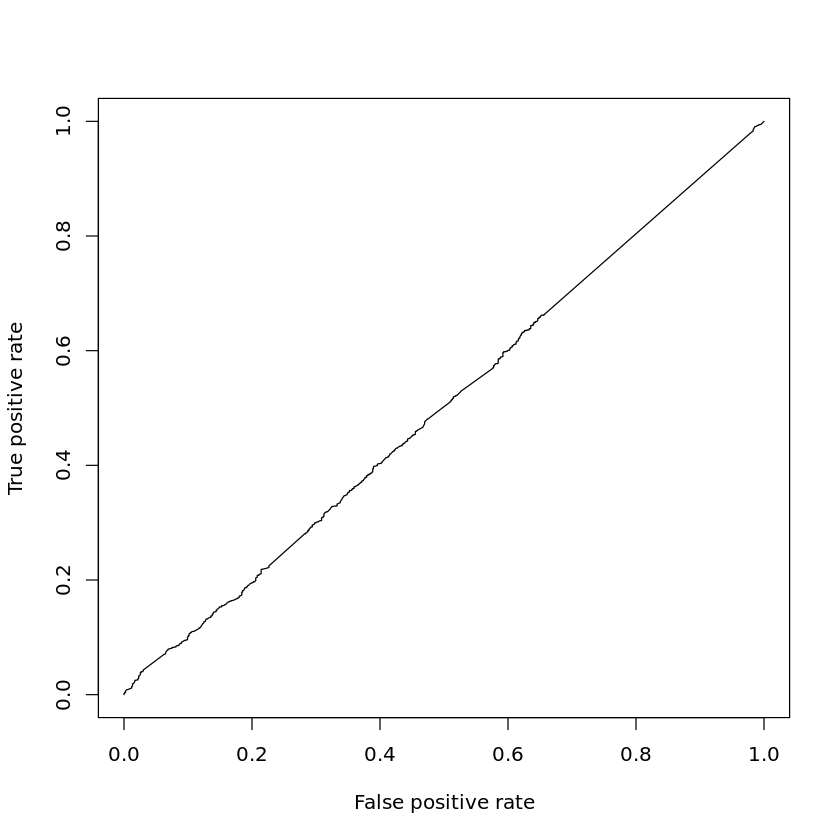

In [122]:
evaluate(pVals = limma_res, cell_group='Group2', gene_attrs=rowData(sg), gene_names=rownames(sg))

## DESeq

In [163]:
# *** Running DESeq:

Run_DESeq = function(rawData , gr1 , gr2){
  
  require("DESeq")
  
  # First the genes with 0 value for all the cells were filtered out:
  
  filtered = apply(rawData,1, function(x) {if(all(x == 0)) return (FALSE) else return(TRUE)})
  
  FilteredData = rawData[filtered,]
  
  # Defining the sample's description and conditions:
  
  #dataPack = data.frame(row.names= colnames(FilteredData), condition = c(rep("GR1",dim(gr1)[2]) ,rep("GR2",dim(gr2)[2])))
  
  conds <- factor (c(rep("GR1",dim(gr1)[2]) ,rep("GR2",dim(gr2)[2])))
  
  #print(conds)
      
  # Initializing a CountDataSet (DESeq data structure for count matrix):
  
  cds <- newCountDataSet(FilteredData, conds)
  
  # DESeq normaliztion:
  
  cds <- estimateSizeFactors (cds)
  #print (sizeFactors(cds))
  #print (head(counts(cds, normalized = TRUE)))
  
  # Variance estimation:
  
  cds <- estimateDispersions (cds)
  
  #print(str(fitInfo(cds)))
  
  # Negative binomial test:
  
  DESeq_results = nbinomTest(cds, "GR1", "GR2")
  
  return (DESeq_results)
      
  #save(DESeq_results, file ="DESeq_results.RData")
  
}

In [174]:
cds <- makeExampleCountDataSet()


ERROR: Error in makeExampleCountDataSet(counts): unused argument (counts)


In [175]:
groups

[1] "Group2" "Group2" "Group1" "Group1" "Group2" "Group1" "Group1" "Group1"
 [9] "Group2" "Group2" "Group1" "Group2" "Group1" "Group2" "Group2" "Group1"
[17] "Group2" "Group2" "Group1" "Group1" "Group1" "Group1" "Group1" "Group2"
[25] "Group1" "Group1" "Group2" "Group1" "Group1" "Group2" "Group1" "Group1"
[33] "Group1" "Group1" "Group2" "Group1" "Group2" "Group1" "Group2" "Group2"
[41] "Group1" "Group2" "Group2" "Group2" "Group1" "Group2" "Group1" "Group1"
[49] "Group2" "Group2"

In [189]:
cds <- newCountDataSet(counts, groups)

In [193]:
cds

CountDataSet (storageMode: environment)
assayData: 19928 features, 50 samples 
  element names: counts 
protocolData: none
phenoData
  sampleNames: Cell1 Cell2 ... Cell50 (50 total)
  varLabels: sizeFactor condition
  varMetadata: labelDescription
featureData: none
experimentData: use 'experimentData(object)'
Annotation:  

In [194]:
cds <- estimateSizeFactors( cds )

In [196]:
sizeFactors(cds)

Cell1  Cell2  Cell3  Cell4  Cell5  Cell6  Cell7  Cell8  Cell9 Cell10 Cell11 
    NA     NA     NA     NA     NA     NA     NA     NA     NA     NA     NA 
Cell12 Cell13 Cell14 Cell15 Cell16 Cell17 Cell18 Cell19 Cell20 Cell21 Cell22 
    NA     NA     NA     NA     NA     NA     NA     NA     NA     NA     NA 
Cell23 Cell24 Cell25 Cell26 Cell27 Cell28 Cell29 Cell30 Cell31 Cell32 Cell33 
    NA     NA     NA     NA     NA     NA     NA     NA     NA     NA     NA 
Cell34 Cell35 Cell36 Cell37 Cell38 Cell39 Cell40 Cell41 Cell42 Cell43 Cell44 
    NA     NA     NA     NA     NA     NA     NA     NA     NA     NA     NA 
Cell45 Cell46 Cell47 Cell48 Cell49 Cell50 
    NA     NA     NA     NA     NA     NA

In [191]:
?estimateSizeFactors

In [188]:
cds2 <- makeExampleCountDataSet()
cds2

CountDataSet (storageMode: environment)
assayData: 10000 features, 5 samples 
  element names: counts 
protocolData: none
phenoData
  sampleNames: A1 A2 ... B3 (5 total)
  varLabels: sizeFactor condition
  varMetadata: labelDescription
featureData: none
experimentData: use 'experimentData(object)'
Annotation:  

In [192]:
cds2 <- estimateSizeFactors( cds2 )
sizeFactors( cds2 )

A1        A2        B1        B2        B3 
0.9660585 1.2563277 0.6810029 0.8709338 1.5578652

In [164]:
deseq_res = Run_DESeq(counts, gr1, gr2)

ERROR: Error in .local(object, ...): NAs found in size factors. Have you called already 'estimateSizeFactors'?


## DESeq2

In [18]:
dds <- DESeqDataSetFromMatrix(countData = round(counts), 
                                    colData = data.frame(condition = groups), 
                                    design = ~condition)
      dds <- DESeq(dds, minReplicatesForReplace = Inf)
      res <- results(dds, contrast = c("condition", levels(factor(groups))[1], 
levels(factor(groups))[2]), alpha = 0.05)

converting counts to integer mode
estimating size factors


ERROR: Error in estimateSizeFactorsForMatrix(counts(object), locfunc = locfunc, : every gene contains at least one zero, cannot compute log geometric means
